### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [ ]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [ ]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-12-02 16:40:44--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2024-12-02 16:40:45 (8.35 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [ ]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [ ]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [ ]:
next(generate_chunk())

array([[83, 53, 63, ..., 45, 58, 58],
       [83, 72, 54, ..., 59, 49,  1],
       [83, 62, 47, ..., 46, 50, 51],
       ...,
       [83, 50, 58, ..., 63, 73, 76],
       [83, 58, 64, ..., 53, 57,  1],
       [83, 60, 50, ..., 62, 68, 45]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        out, hidden = self.rnn(embedded, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        return out, hidden

def sample_with_temperature(logits, temperature=1.0):
    probs = F.softmax(logits / temperature, dim=-1)
    return torch.multinomial(probs, 1)

def generate_text(model, start_string, length=100, temperature=1.0):
    model.eval()
    input_seq = torch.tensor([token_to_idx['<sos>']] + [token_to_idx[ch] for ch in start_string],
                             dtype=torch.long).unsqueeze(0).to(device)
    hidden = None
    generated = start_string

    with torch.no_grad():
        for _ in range(length):
            output, hidden = model(input_seq, hidden)
            next_char_idx = sample_with_temperature(output[:, -1, :], temperature).item()
            next_char = idx_to_token[next_char_idx]
            generated += next_char
            input_seq = torch.tensor([[next_char_idx]], dtype=torch.long).to(device)

    return generated

embedding_dim = 256
hidden_dim = 512
num_epochs = 30

model = VanillaRNN(num_tokens, embedding_dim, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    total_loss = 0
    for batch in generate_chunk():
        batch = torch.tensor(batch, dtype=torch.long).to(device)
        inputs, targets = batch[:, :-1], batch[:, 1:]
        hidden = None

        optimizer.zero_grad()
        outputs, hidden = model(inputs, hidden)

        loss = criterion(outputs.reshape(-1, num_tokens), targets.reshape(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")

start_string = "мой дядя самых честных правил"
temperature = 0.8
generated_text = generate_text(model, start_string, length=200, temperature=temperature)
print(generated_text)

Epoch 1/30, Loss: 4.4697
Epoch 2/30, Loss: 4.1686
Epoch 3/30, Loss: 3.8559
Epoch 4/30, Loss: 3.4502
Epoch 5/30, Loss: 3.2818
Epoch 6/30, Loss: 3.1214
Epoch 7/30, Loss: 3.0721
Epoch 8/30, Loss: 3.0212
Epoch 9/30, Loss: 2.9867
Epoch 10/30, Loss: 2.9034
Epoch 11/30, Loss: 2.8683
Epoch 12/30, Loss: 2.8306
Epoch 13/30, Loss: 2.8019
Epoch 14/30, Loss: 2.7780
Epoch 15/30, Loss: 2.7879
Epoch 16/30, Loss: 2.7559
Epoch 17/30, Loss: 2.7096
Epoch 18/30, Loss: 2.6810
Epoch 19/30, Loss: 2.6727
Epoch 20/30, Loss: 2.6484
Epoch 21/30, Loss: 2.6505
Epoch 22/30, Loss: 2.5979
Epoch 23/30, Loss: 2.6353
Epoch 24/30, Loss: 2.5931
Epoch 25/30, Loss: 2.5826
Epoch 26/30, Loss: 2.5588
Epoch 27/30, Loss: 2.5513
Epoch 28/30, Loss: 2.5449
Epoch 29/30, Loss: 2.5564
Epoch 30/30, Loss: 2.5285
мой дядя самых честных правила тан жоной,
но не
пра; ноймиле вомочо шуго, де сели боол я с оно ведной рум причит,
искиз яной презами врgзаяный
одат пой ладарный прала ужа погобильюи номно ночиза дасли ожеть ой вим потья в оот про

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

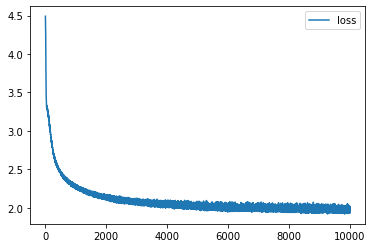

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    hidden = None
    generated_text = seed_phrase if seed_phrase else ''

    for _ in range(max_length - len(generated_text)):
      output, hidden = char_rnn(x_sequence, hidden)

      logits = output[:, -1, :]

      next_char_idx = sample_with_temperature(logits, temperature).item()
      next_char = idx_to_token[next_char_idx]

      generated_text += next_char

      x_sequence = torch.tensor([[next_char_idx]], dtype=torch.int64).to(device)

    return generated_text

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

 мой дядя самых честных правиледо мом ной неч.


вавси таят
и ствней,
вомою пони у скавста.


xviii


бе друтит,
ины,
я мета ведать исотомый
воть васкол,
глегоже дель неть бася нетим жазны презно ный воты мочне пренно выдали совецде, волени уматья

xxxi[ здой мну
и де точанико мона, толоные м бого не тевла молан,
таль нолатраво, мечный,
к бузьы вони томорне трали
 него та веет поленной чна пелонепесьяся онна нася,
и плыня с калу!т,лено боста! трочусьены я игедне т радель лола стову,
т зазлали со


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [ ]:
generated_phrases = [
    generate_sample(
        model,
        seed_phrase,
        max_length=500,
        temperature=0.8
    ).replace('<sos>', '')
    for _ in range(10)
]

In [ ]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!

In [ ]:
# Улучшенные гиперпараметры
embedding_dim = 512
hidden_dim = 1024
num_epochs = 50

model = VanillaRNN(num_tokens, embedding_dim, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    total_loss = 0
    for batch in generate_chunk():
        batch = torch.tensor(batch, dtype=torch.long).to(device)
        inputs, targets = batch[:, :-1], batch[:, 1:]
        hidden = None

        optimizer.zero_grad()
        outputs, hidden = model(inputs, hidden)
        loss = criterion(outputs.reshape(-1, num_tokens), targets.reshape(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")

# Генерация 10 последовательностей
seed_phrase = ' мой дядя самых честных правил'
temperature = 1.
generated_phrases = [
    generate_sample(model, seed_phrase, max_length=500, temperature=temperature).replace('<sos>', '')
    for _ in range(10)
]

# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________


Epoch 1/50, Loss: 4.4803
Epoch 2/50, Loss: 3.7711
Epoch 3/50, Loss: 3.1557
Epoch 4/50, Loss: 3.0955
Epoch 5/50, Loss: 2.9120
Epoch 6/50, Loss: 2.8293
Epoch 7/50, Loss: 2.7734
Epoch 8/50, Loss: 2.7032
Epoch 9/50, Loss: 2.6708
Epoch 10/50, Loss: 2.6448
Epoch 11/50, Loss: 2.6296
Epoch 12/50, Loss: 2.6335
Epoch 13/50, Loss: 2.5643
Epoch 14/50, Loss: 2.5244
Epoch 15/50, Loss: 2.5300
Epoch 16/50, Loss: 2.5470
Epoch 17/50, Loss: 2.5108
Epoch 18/50, Loss: 2.4638
Epoch 19/50, Loss: 2.4441
Epoch 20/50, Loss: 2.4772
Epoch 21/50, Loss: 2.4649
Epoch 22/50, Loss: 2.4827
Epoch 23/50, Loss: 2.4636
Epoch 24/50, Loss: 2.4458
Epoch 25/50, Loss: 2.4439
Epoch 26/50, Loss: 2.3792
Epoch 27/50, Loss: 2.4171
Epoch 28/50, Loss: 2.3990
Epoch 29/50, Loss: 2.3797
Epoch 30/50, Loss: 2.3498
Epoch 31/50, Loss: 2.3677
Epoch 32/50, Loss: 2.3759
Epoch 33/50, Loss: 2.3740
Epoch 34/50, Loss: 2.3151
Epoch 35/50, Loss: 2.3485
Epoch 36/50, Loss: 2.3579
Epoch 37/50, Loss: 2.3378
Epoch 38/50, Loss: 2.3283
Epoch 39/50, Loss: 2.